# Recruit Restaurant Visitor Forecasting

website = https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting/data

Running a thriving local restaurant isn't always as charming as first impressions appear. There are often all sorts of unexpected troubles popping up that could hurt business.

One common predicament is that restaurants need to know how many customers to expect each day to effectively purchase ingredients and schedule staff members. This forecast isn't easy to make because many unpredictable factors affect restaurant attendance, like weather and local competition. It's even harder for newer restaurants with little historical data.

Recruit Holdings has unique access to key datasets that could make automated future customer prediction possible. Specifically, Recruit Holdings owns **Hot Pepper Gourmet (a restaurant review service), AirREGI (a restaurant point of sales service), and Restaurant Board (reservation log management software)**.

In this competition, you're challenged to use reservation and visitation data to predict the total number of visitors to a restaurant for future dates. This information will help restaurants be much more efficient and allow them to focus on creating an enjoyable dining experience for their customers.

In this competition, you are provided a time-series forecasting problem centered around restaurant visitors. The data comes from two separate sites:

    Hot Pepper Gourmet (hpg): similar to Yelp, here users can search restaurants and also make a reservation online
    AirREGI / Restaurant Board (air): similar to Square, a reservation control and cash register system

**You must use the reservations, visits, and other information from these sites**  to forecast future restaurant visitor totals on a given date. The **training data covers the dates from 2016 until April 2017**. The **test set covers the last week of April and May of 2017**. The test set is split based on time (the public fold coming first, the private fold following the public) and covers a chosen subset of the air restaurants. **Note that the test set intentionally spans a holiday week in Japan called the "Golden Week."**

**There are days in the test set where the restaurant were closed and had no visitors. These are ignored in scoring. The training set omits days where the restaurants were closed.**


File Descriptions

This is a relational dataset from two systems. Each file is prefaced with the source (either air_ or hpg_) to indicate its origin. Each restaurant has a unique air_store_id and hpg_store_id. Note that not all restaurants are covered by both systems, and that you have been provided data beyond the restaurants for which you must forecast. Latitudes and Longitudes are not exact to discourage de-identification of restaurants.

air_reserve.csv

This file contains reservations made in the air system. Note that the reserve_datetime indicates the time when the reservation was created, whereas the visit_datetime is the time in the future where the visit will occur.

    air_store_id - the restaurant's id in the air system
    visit_datetime - the time of the reservation
    reserve_datetime - the time the reservation was made
    reserve_visitors - the number of visitors for that reservation

hpg_reserve.csv

This file contains reservations made in the hpg system.

    hpg_store_id - the restaurant's id in the hpg system
    visit_datetime - the time of the reservation
    reserve_datetime - the time the reservation was made
    reserve_visitors - the number of visitors for that reservation

air_store_info.csv

This file contains information about select air restaurants. Column names and contents are self-explanatory.

    air_store_id
    air_genre_name
    air_area_name
    latitude
    longitude

Note: latitude and longitude are the latitude and longitude of the area to which the store belongs
hpg_store_info.csv

This file contains information about select hpg restaurants. Column names and contents are self-explanatory.

    hpg_store_id
    hpg_genre_name
    hpg_area_name
    latitude
    longitude

Note: latitude and longitude are the latitude and longitude of the area to which the store belongs
store_id_relation.csv

This file allows you to join select restaurants that have both the air and hpg system.

    hpg_store_id
    air_store_id

air_visit_data.csv

This file contains historical visit data for the air restaurants.

    air_store_id
    visit_date - the date
    visitors - the number of visitors to the restaurant on the date

sample_submission.csv

This file shows a submission in the correct format, including the days for which you must forecast.

    id - the id is formed by concatenating the air_store_id and visit_date with an underscore
    visitors- the number of visitors forecasted for the store and date combination

date_info.csv

This file gives basic information about the calendar dates in the dataset.

    calendar_date
    day_of_week
    holiday_flg - is the day a holiday in Japan


In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.base import BaseEstimator, TransformerMixin
from pathlib import Path
from datetime import timedelta
import matplotlib.ticker as ticker

In [2]:
user = '/WilliamHoltam'  # Configure this with your username

data_repo = Path(
    r'C:\Users' +
    user +
    '\Datalytyx\Delivery - Documents\Data Science\Data\Recruit_Restaurant_Visitor_Forecasting'
)

data_list = [
    'air_reserve.csv',
    'air_store_info.csv',
    'air_visit_data.csv',
    'date_info.csv',
    'hpg_reserve.csv',
    'hpg_store_info.csv',
    'store_id_relation.csv'
]

air_reserve = pd.read_csv(data_repo/'air_reserve.csv', parse_dates=['visit_datetime', 'reserve_datetime'])  # Reservations made in the air system.
air_store_info = pd.read_csv(data_repo/'air_store_info.csv')  # Information about select air restaurants
air_visit_data = pd.read_csv(data_repo/'air_visit_data.csv', parse_dates=['visit_date'])  # Historical visit data for the air restaurants.
date_info = pd.read_csv(data_repo/'date_info.csv')  # Basic information about the calendar dates in the dataset.
hpg_reserve = pd.read_csv(data_repo/'hpg_reserve.csv', parse_dates=['visit_datetime', 'reserve_datetime'])  # Reservations made in the hpg system.
hpg_store_info = pd.read_csv(data_repo/'hpg_store_info.csv')  # Information about select hpg restaurants
store_id_relation = pd.read_csv(data_repo/'store_id_relation.csv')  # This file allows you to join select restaurants that have both the air and hpg system.

sample_submission = pd.read_csv(data_repo/'sample_submission.csv')  # Submission example

In [3]:
class DateFromDateType64Extractor(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        
        self.dt_columns = X.select_dtypes(include='datetime64').columns.values.tolist()

        return self
    
    def transform(self, X):
    
        for i in self.dt_columns:
            X[i+'_date'] = X[i].dt.date  # use pandas dt method as it is vectorised and therfore produces the result fastest
            X[i+'_time'] = X[i].dt.time
        
        print("The following columns contain datetime64 data: ")
        print(self.dt_columns)
        print("")
        
        return X
    
air_reserve = DateFromDateType64Extractor().fit_transform(air_reserve)
hpg_reserve = DateFromDateType64Extractor().fit_transform(hpg_reserve)

The following columns contain datetime64 data: 
['visit_datetime', 'reserve_datetime']

The following columns contain datetime64 data: 
['visit_datetime', 'reserve_datetime']



In [4]:
air_reserve.info()
air_reserve.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92378 entries, 0 to 92377
Data columns (total 8 columns):
air_store_id             92378 non-null object
visit_datetime           92378 non-null datetime64[ns]
reserve_datetime         92378 non-null datetime64[ns]
reserve_visitors         92378 non-null int64
visit_datetime_date      92378 non-null object
visit_datetime_time      92378 non-null object
reserve_datetime_date    92378 non-null object
reserve_datetime_time    92378 non-null object
dtypes: datetime64[ns](2), int64(1), object(5)
memory usage: 5.6+ MB


,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,visit_datetime_date,visit_datetime_time,reserve_datetime_date,reserve_datetime_time
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,2016-01-01,19:00:00,2016-01-01,16:00:00
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3,2016-01-01,19:00:00,2016-01-01,19:00:00


In [5]:
air_store_info.info()
air_store_info.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829 entries, 0 to 828
Data columns (total 5 columns):
air_store_id      829 non-null object
air_genre_name    829 non-null object
air_area_name     829 non-null object
latitude          829 non-null float64
longitude         829 non-null float64
dtypes: float64(2), object(3)
memory usage: 32.5+ KB


,air_store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852


In [6]:
air_visit_data.info()
air_visit_data.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252108 entries, 0 to 252107
Data columns (total 3 columns):
air_store_id    252108 non-null object
visit_date      252108 non-null datetime64[ns]
visitors        252108 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 5.8+ MB


,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32


In [7]:
date_info.info()
date_info.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 3 columns):
calendar_date    517 non-null object
day_of_week      517 non-null object
holiday_flg      517 non-null int64
dtypes: int64(1), object(2)
memory usage: 12.2+ KB


,calendar_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1


In [8]:
hpg_reserve.info()
hpg_reserve.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000320 entries, 0 to 2000319
Data columns (total 8 columns):
hpg_store_id             object
visit_datetime           datetime64[ns]
reserve_datetime         datetime64[ns]
reserve_visitors         int64
visit_datetime_date      object
visit_datetime_time      object
reserve_datetime_date    object
reserve_datetime_time    object
dtypes: datetime64[ns](2), int64(1), object(5)
memory usage: 122.1+ MB


,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors,visit_datetime_date,visit_datetime_time,reserve_datetime_date,reserve_datetime_time
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1,2016-01-01,11:00:00,2016-01-01,09:00:00
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3,2016-01-01,13:00:00,2016-01-01,06:00:00


In [9]:
hpg_store_info.info()
hpg_store_info.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4690 entries, 0 to 4689
Data columns (total 5 columns):
hpg_store_id      4690 non-null object
hpg_genre_name    4690 non-null object
hpg_area_name     4690 non-null object
latitude          4690 non-null float64
longitude         4690 non-null float64
dtypes: float64(2), object(3)
memory usage: 183.3+ KB


,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude
0,hpg_6622b62385aec8bf,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
1,hpg_e9e068dd49c5fa00,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221


In [10]:
store_id_relation.info()
store_id_relation.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 2 columns):
air_store_id    150 non-null object
hpg_store_id    150 non-null object
dtypes: object(2)
memory usage: 2.4+ KB


,air_store_id,hpg_store_id
0,air_63b13c56b7201bd9,hpg_4bc649e72e2a239a
1,air_a24bf50c3e90d583,hpg_c34b496d0305a809


## EDA Examine Visitor Numbers Over Time (air_visit_data) as it is the training data

In [11]:
air_visit_data.head(3)

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29


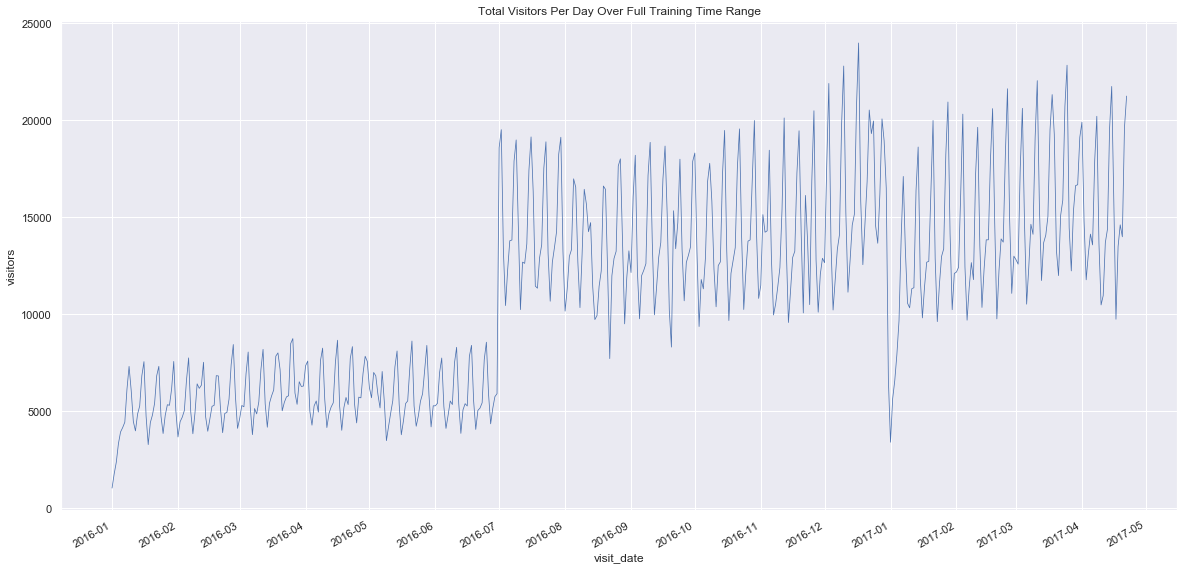

In [12]:
data = air_visit_data.groupby(["visit_date"]).sum().reset_index()

sns.set(style="darkgrid")

fig, ax = plt.subplots(figsize=(20,10))

ax = sns.lineplot(
    x="visit_date",
    y="visitors",
    size=3.0,
    data=data,
    legend=False
)

fig.autofmt_xdate()

ax.xaxis.set_major_locator(mdates.MonthLocator())
plt.title('Total Visitors Per Day Over Full Training Time Range')

plt.show()

* Long-term step structure

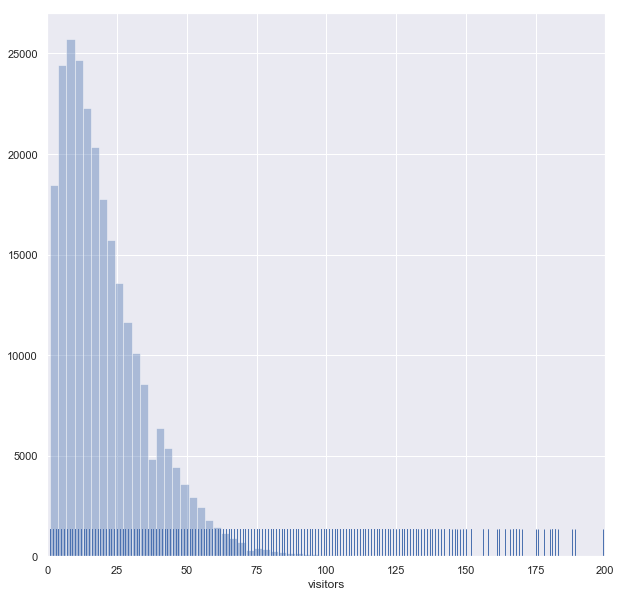

In [13]:
fig, ax = plt.subplots(figsize=(10,10))

data = air_visit_data

sns.distplot(
    a=data["visitors"],
    hist=True,
    kde=False,
    rug=True,
    bins=300
)

plt.xlim(0.00,200)

plt.show()

* The number of guests per visit per restaurant per day peaks at around 20. 
* The distribution extends up to 100 occasionally beyond.

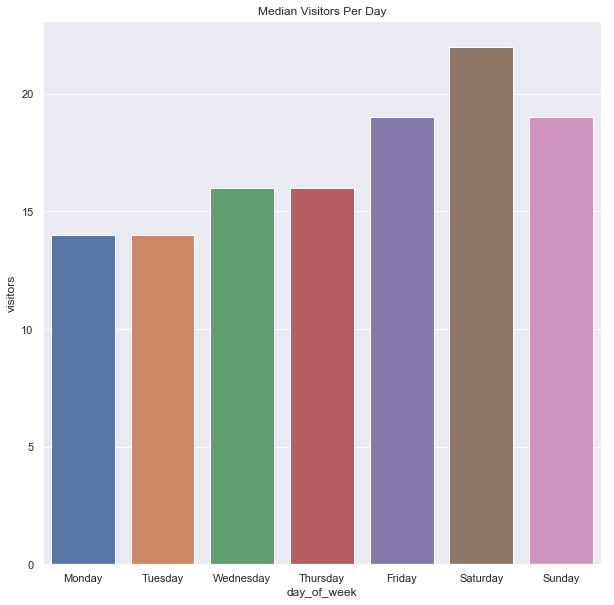

In [14]:
air_visit_data["day_of_week"] = air_visit_data["visit_date"].dt.day_name()
air_visit_data["day_of_week_no"] = air_visit_data['visit_date'].dt.dayofweek

data = air_visit_data.groupby("day_of_week").median().sort_values("day_of_week_no").reset_index()

# data = data.drop(["day_of_week_no"], axis=1)

fig, ax = plt.subplots(figsize=(10,10))

sns.barplot(
    x="day_of_week",
    y="visitors",
    data=data,
    estimator=np.median
)

plt.title("Median Visitors Per Day")

plt.show()

* Friday and the weekend appear to be the most popular days; which is to be expected.
* Monday and Tuesday have the lowest numbers of average visitors.

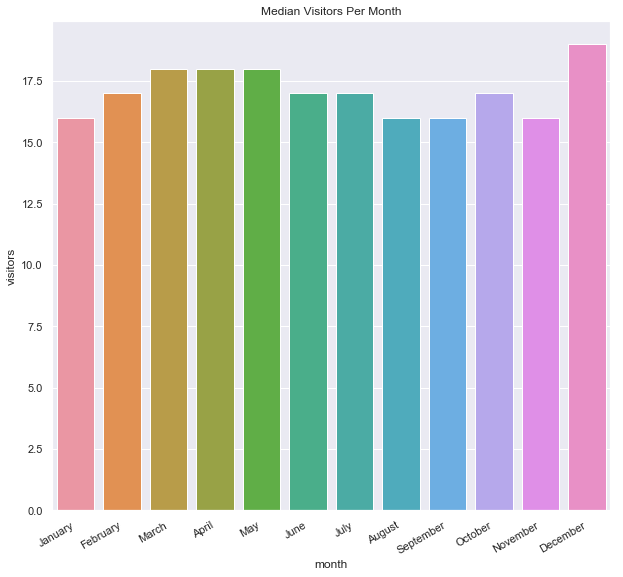

In [15]:
air_visit_data["month"] = air_visit_data["visit_date"].dt.month_name()
air_visit_data["month_no"] = air_visit_data['visit_date'].dt.month

data = air_visit_data.groupby("month").median().sort_values("month_no").reset_index()

fig, ax = plt.subplots(figsize=(10,10))

sns.barplot(
    x="month",
    y="visitors",
    data=data,
    estimator=np.median
)

plt.title("Median Visitors Per Month")

fig.autofmt_xdate()

plt.show()

* Seasonality through out the year. Dec is the most popular month for restaurant visits.
* The period of Mar - May is consistently busy.

We will be forecasting the last week of April + May 2017 so look at this time range in the 2016 training data:

In [16]:
data = air_visit_data.loc[np.logical_and(air_visit_data["visit_date"] > "2016-04-15", air_visit_data["visit_date"] < "2016-06-15")]
data = data.groupby(by="visit_date").sum().reset_index()
data.head()

,visit_date,visitors,day_of_week_no,month_no
0,2016-04-16,8656,1460,1168
1,2016-04-17,5253,1320,880
2,2016-04-18,4011,0,932
3,2016-04-19,5181,272,1088
4,2016-04-20,5706,562,1124


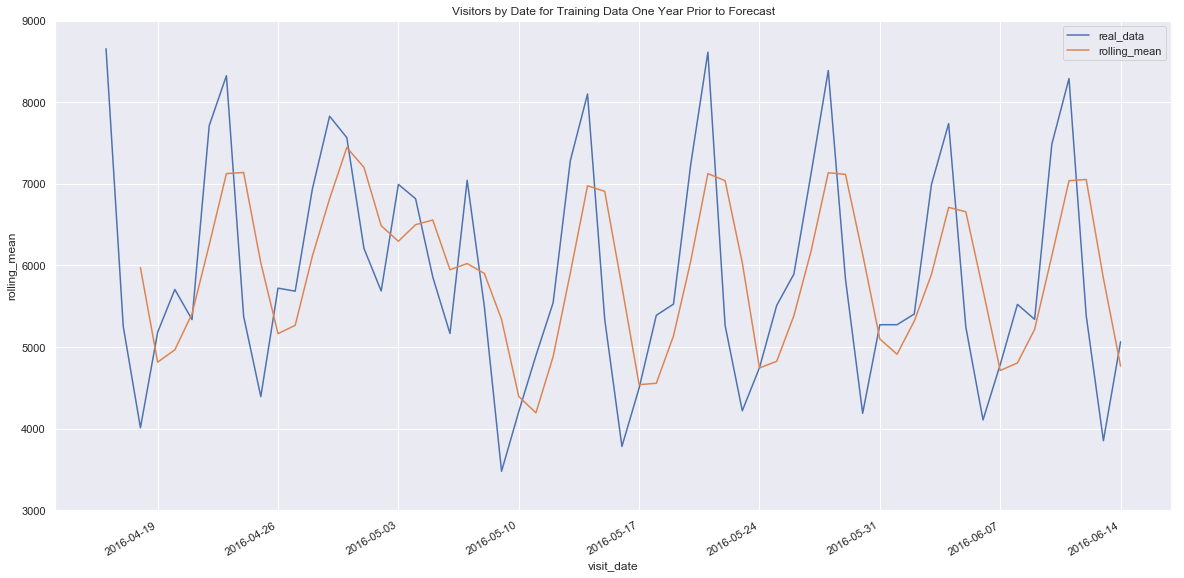

In [17]:
data["rolling_mean"] = data["visitors"].rolling(3).mean()

fig, ax = plt.subplots(figsize=(20,10))

sns.lineplot(
    x="visit_date",
    y="visitors",
    data=data,
    label="real_data"
)

sns.lineplot(
    x="visit_date",
    y="rolling_mean",
    data=data,
    label="rolling_mean"
)

plt.title("Visitors by Date for Training Data One Year Prior to Forecast")

plt.ylim(3000,9000)

fig.autofmt_xdate()

plt.show()

You can see the weekly seasonality, paticularly in the rolling mean plot. The holiday mentioned in the description "The Golden Week" is clearly visible ~ between 2-16-05-01 and 2016-05-09

## EDA Compare Air Reservation Data (air_reserve) to Visitor Numbers (air_visit_data)

In [18]:
air_reserve.head(3)

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,visit_datetime_date,visit_datetime_time,reserve_datetime_date,reserve_datetime_time
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,2016-01-01,19:00:00,2016-01-01,16:00:00
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3,2016-01-01,19:00:00,2016-01-01,19:00:00
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6,2016-01-01,19:00:00,2016-01-01,19:00:00


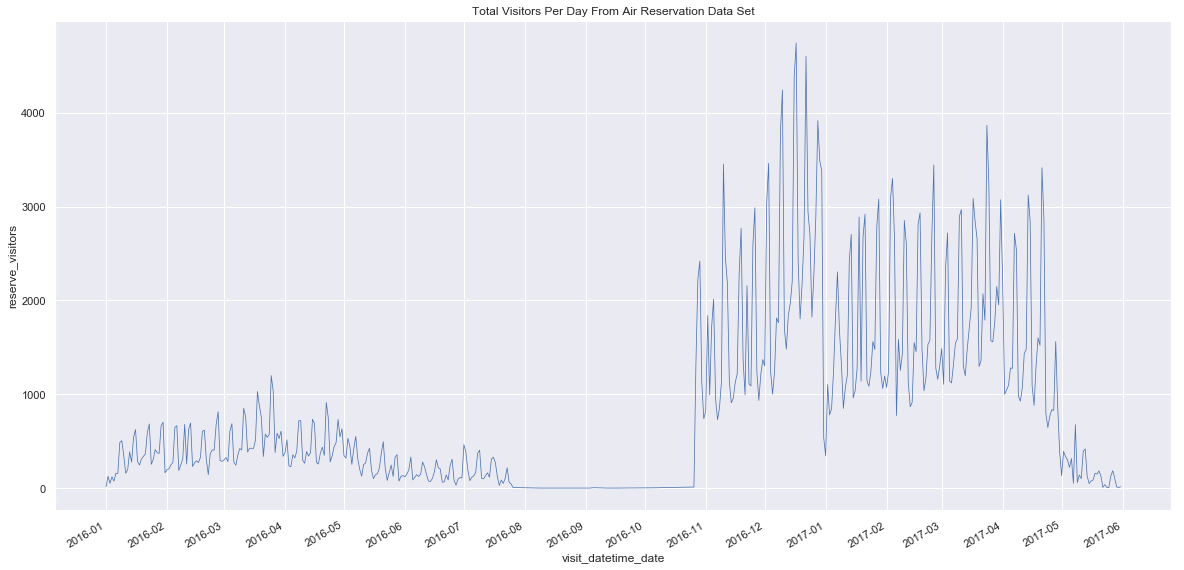

In [19]:
data = air_reserve.groupby(["visit_datetime_date"]).sum().reset_index()

sns.set(style="darkgrid")

fig, ax = plt.subplots(figsize=(20,10))

ax = sns.lineplot(
    x="visit_datetime_date",
    y="reserve_visitors",
    size=3.0,
    data=data,
    legend=False
)

fig.autofmt_xdate()

ax.xaxis.set_major_locator(mdates.MonthLocator())
plt.title('Total Visitors Per Day From Air Reservation Data Set')

plt.show()

* Fewer Reservations made through air system in 2016. None at all between 2016-08 and 2016-11
* The decline we see after the first quarter is most likely related to these reservations being at the end of the training time frame, which means that long-term reservations would not be part of this data set.

[]

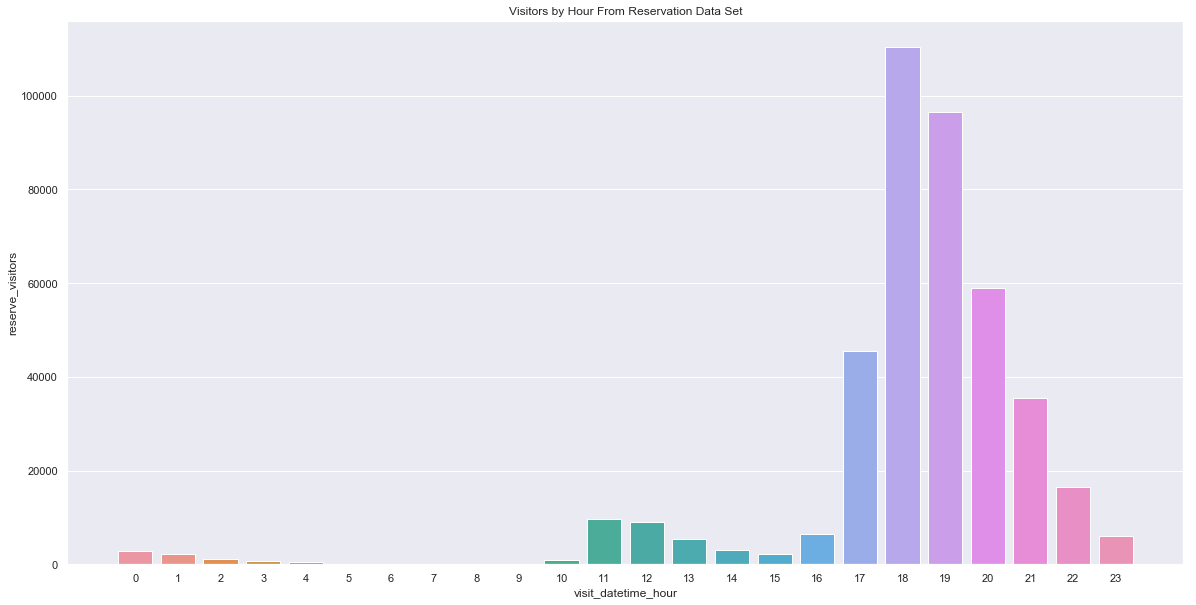

In [20]:
air_reserve["visit_datetime_hour"] = air_reserve["visit_datetime"].dt.hour
data = air_reserve.groupby(["visit_datetime_hour"]).sum().reset_index()

sns.set(style="darkgrid")

fig, ax = plt.subplots(figsize=(20,10))

sns.barplot(
    x="visit_datetime_hour",
    y="reserve_visitors",
    data=data
)

plt.title("Visitors by Hour From Reservation Data Set")

plt.plot()

* Reservations are made typically for the dinner hours in the evening.

[]

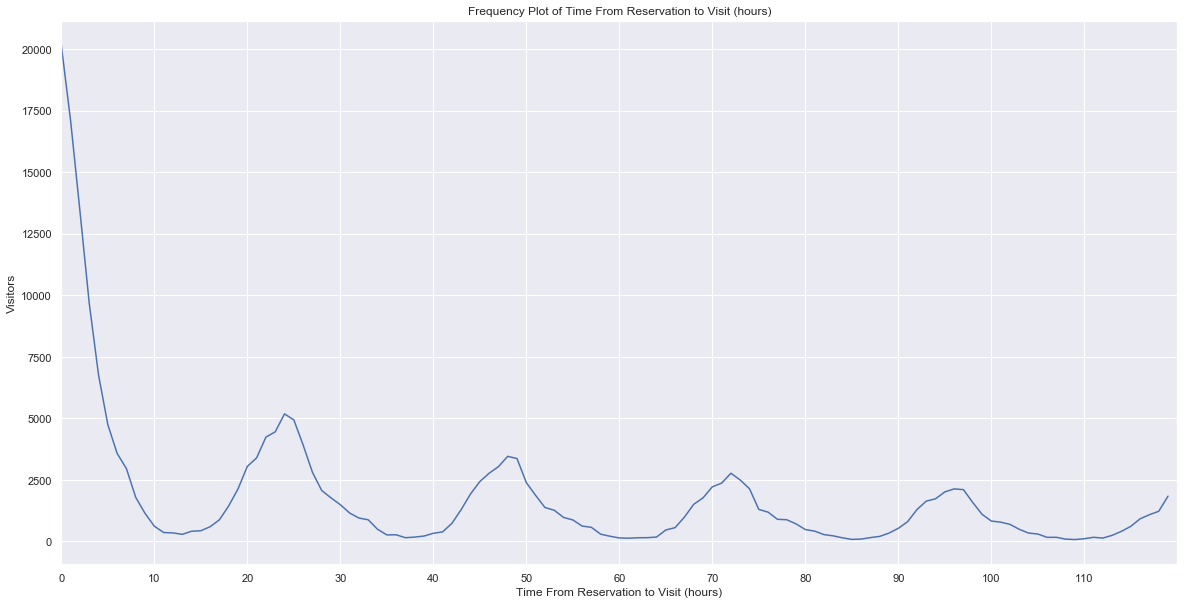

In [21]:
air_reserve["time_reserve_to_visit"] = air_reserve["visit_datetime"] - air_reserve["reserve_datetime"]
air_reserve["time_reserve_to_visit"] = (air_reserve["time_reserve_to_visit"]/timedelta(hours=1)).astype(int)

data_cutoff = 24*5

data = air_reserve.groupby(["time_reserve_to_visit"]).sum().reset_index()
data = data.loc[data["time_reserve_to_visit"] < data_cutoff]
x="time_reserve_to_visit"
y="reserve_visitors"

sns.set(style="darkgrid")

fig, ax = plt.subplots(figsize=(20,10))

sns.lineplot(
    x=x,
    y=y,
    data=data
)

plt.title("Frequency Plot of Time From Reservation to Visit (hours)")
plt.xlabel("Time From Reservation to Visit (hours)")
plt.ylabel("Visitors")

plt.xlim(0,data_cutoff)

start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 10))

plt.plot()

* The time, here shown in hours, between making a reservation and visiting the restaurant follow a nice 24-hour pattern.
* The most popular strategy is to reserve a couple of hours before the visit, but if the reservation is made more in advance then it seems to be common to book a table in the evening for one of the next evenings.
* This plot is truncated to show this pattern, which continues towards longer time scales.
* Very long time gaps between reservation and visit are not uncommon. Those are the most extreme values for the air data, up to more than a year in advance:

## EDA Hot Pepper Gormet (hpg_reserve)

In [22]:
hpg_reserve.head(3)

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors,visit_datetime_date,visit_datetime_time,reserve_datetime_date,reserve_datetime_time
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1,2016-01-01,11:00:00,2016-01-01,09:00:00
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3,2016-01-01,13:00:00,2016-01-01,06:00:00
2,hpg_c8e24dcf51ca1eb5,2016-01-01 16:00:00,2016-01-01 14:00:00,2,2016-01-01,16:00:00,2016-01-01,14:00:00


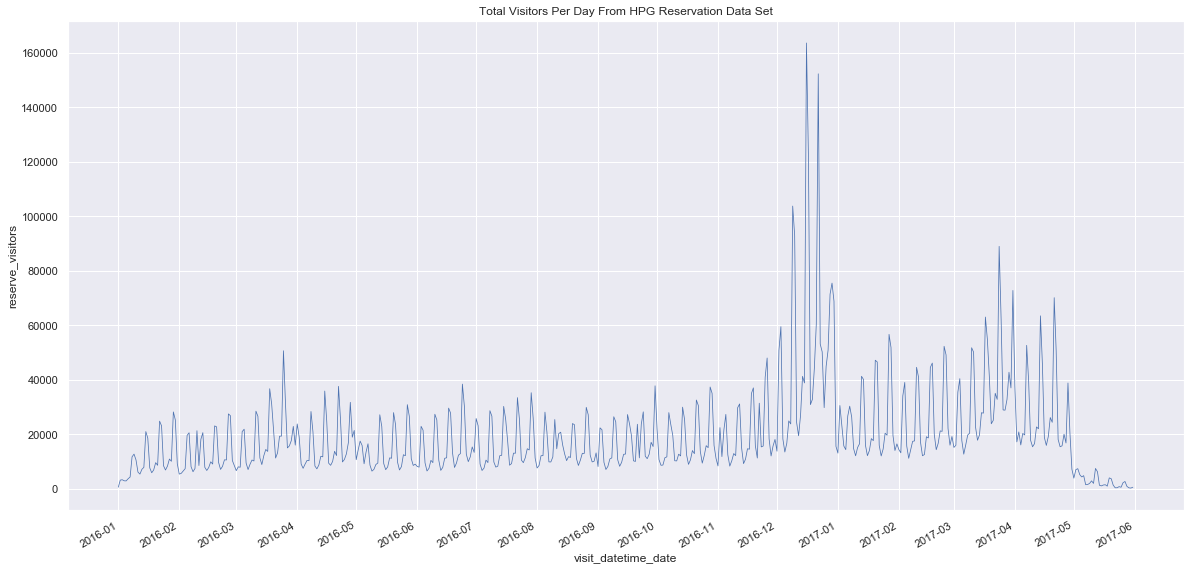

In [23]:
data = hpg_reserve.groupby(["visit_datetime_date"]).sum().reset_index()

sns.set(style="darkgrid")

fig, ax = plt.subplots(figsize=(20,10))

ax = sns.lineplot(
    x="visit_datetime_date",
    y="reserve_visitors",
    size=3.0,
    data=data,
    legend=False
)

fig.autofmt_xdate()

ax.xaxis.set_major_locator(mdates.MonthLocator())
plt.title('Total Visitors Per Day From HPG Reservation Data Set')

plt.show()

[]

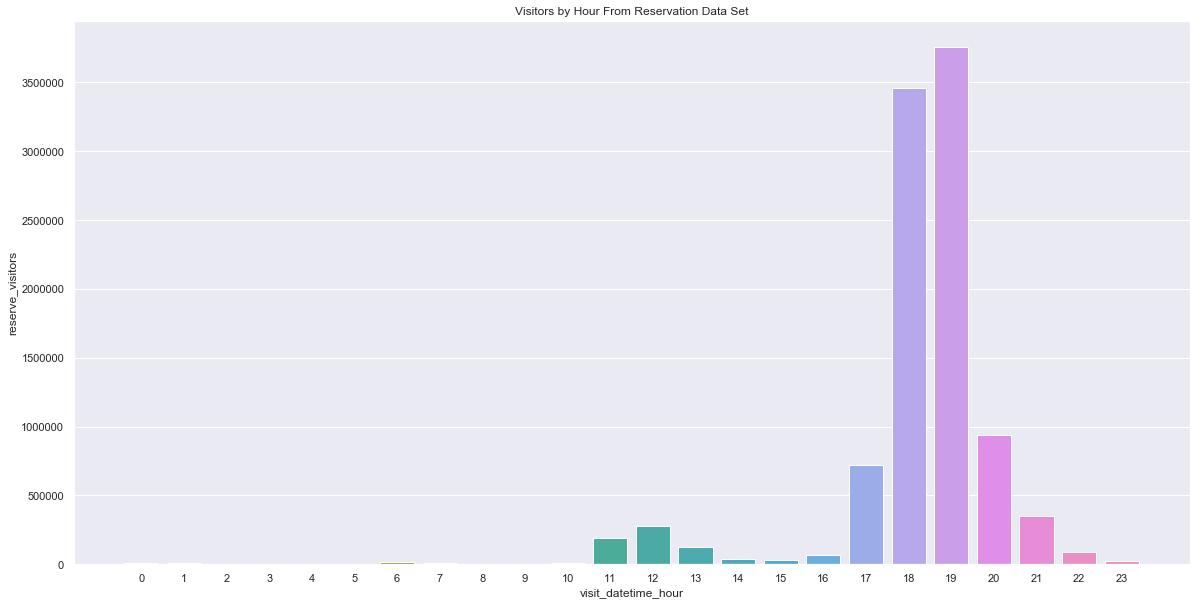

In [24]:
hpg_reserve["visit_datetime_hour"] = hpg_reserve["visit_datetime"].dt.hour
data = hpg_reserve.groupby(["visit_datetime_hour"]).sum().reset_index()

fig, ax = plt.subplots(figsize=(20,10))

sns.set(style="darkgrid")

sns.barplot(
    x="visit_datetime_hour",
    y="reserve_visitors",
    data=data
)

plt.title("Visitors by Hour From Reservation Data Set")

plt.plot()

[]

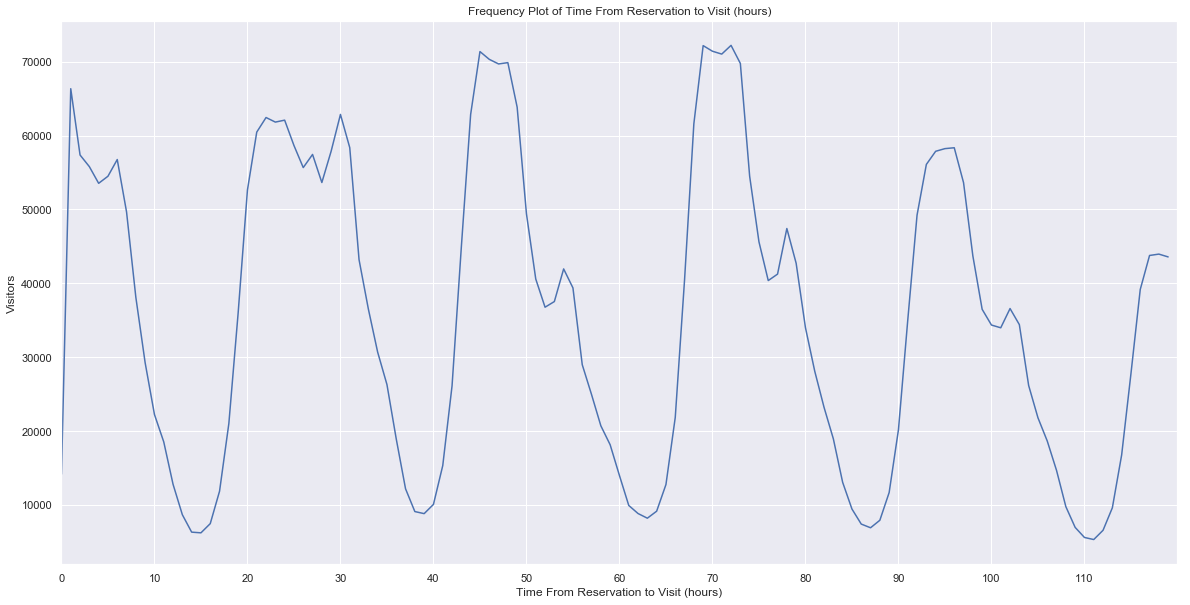

In [26]:
hpg_reserve["time_reserve_to_visit"] = hpg_reserve["visit_datetime"] - hpg_reserve["reserve_datetime"]
hpg_reserve["time_reserve_to_visit"] = (hpg_reserve["time_reserve_to_visit"]/timedelta(hours=1)).astype(int)

data_cutoff = 24*5

data = hpg_reserve.groupby(["time_reserve_to_visit"]).sum().reset_index()
data = data.loc[data["time_reserve_to_visit"] < data_cutoff]
x="time_reserve_to_visit"
y="reserve_visitors"

sns.set(style="darkgrid")

fig, ax = plt.subplots(figsize=(20,10))

sns.lineplot(
    x=x,
    y=y,
    data=data
)

plt.title("Frequency Plot of Time From Reservation to Visit (hours)")
plt.xlabel("Time From Reservation to Visit (hours)")
plt.ylabel("Visitors")

plt.xlim(0,data_cutoff)

start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 10))

plt.plot()

* Here the visits after reservation follow a more orderly pattern, with a clear spike in Dec 2016.As above for the air data, we also see reservation visits dropping off as we get closer to the end of the time frame.
* Again, most reservations are for dinner, and we see another nice 24-hour pattern for making these reservations.
* It’s worth noting that here the last few hours before the visit don’t see more volume than the 24 or 48 hours before. This is in stark constrast to the air data.

## EDA Air Store Info (air_store_info)

Visualise Spatial Information

In [27]:
air_store_info.head(3)

,air_store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852


In [39]:
import folium

ImportError: DLL load failed: The specified module could not be found.

In [43]:
import numpy as np
import pandas as pd
# import geopandas as gpd
import scipy
import shapely
import matplotlib.pyplot as plt
import pysal
import bokeh
import cartopy
import statsmodels
import sklearn
import geoplot
import osmnx
import folium
import dash

ImportError: DLL load failed: The specified module could not be found.